In [13]:
protein_sequence = 'M AVKRPAATKKAGQAKKKKLD SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTL VTTFSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLV NRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLAD HYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK AVKRPAATKKAGQAKKKKLD'
nucleus_image = 'images/nucleus.jpg'

/tmp/ipykernel_3670072/2349121895.py:38: UserWarning: Trying to register the cmap 'rainbow_alpha' which already exists.
  plt.register_cmap(cmap=map_object)


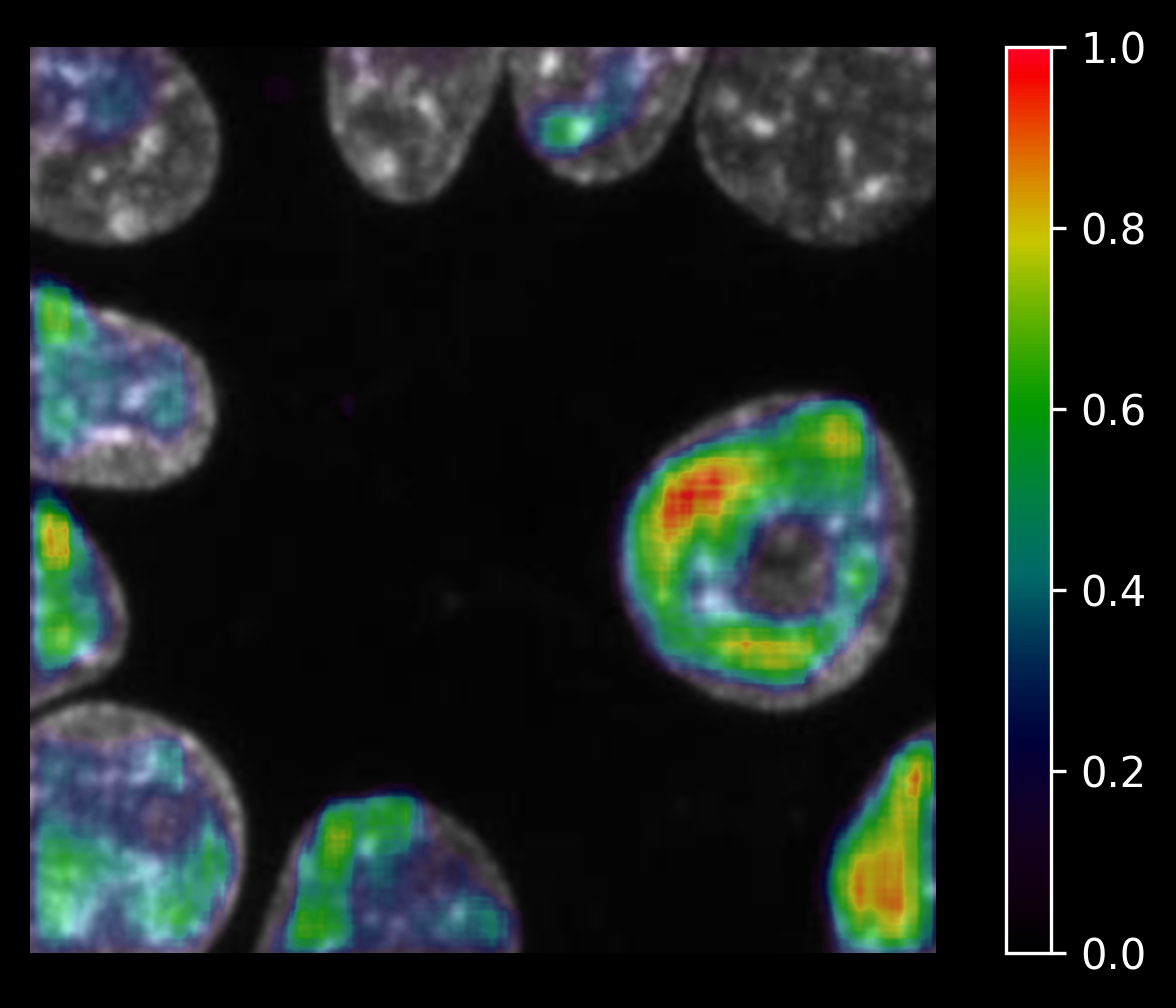

In [14]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import torchvision

from einops import rearrange
from omegaconf import OmegaConf

from tape import TAPETokenizer
from dalle_main import instantiate_from_config

import sys, os

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

protein_sequence = ''.join(filter(str.isalpha, protein_sequence)) 

device = torch.device("cuda:2")
# get colormap
ncolors = 256
color_array = plt.get_cmap('gist_rainbow')(range(ncolors))

# change alpha values
color_array[:,-1] = np.linspace(1.0,0.0,ncolors)

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array[::-1])

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)
blockPrint()
configs = OmegaConf.load('');

model = instantiate_from_config(configs.model).to(device);
enablePrint()
t = torch.load('',map_location = 'cpu')['state_dict'];

for key in list(t.keys()):
    t[key.replace('dalle.','')] = t.pop(key);
model.dalle.load_state_dict(t,strict=False);


model = model.to(device)
model = model.eval()

    
text_seq_len = configs['data']['params']['text_seq_len']
tokenizer = TAPETokenizer(vocab="iupac")

if len(protein_sequence) > text_seq_len:
    start_int = np.random.randint(
        0, len(protein_sequence) - self.text_seq_len
    )
    protein_sequence = protein_sequence[
        start_int : start_int + self.text_seq_len
    ]


# cut off <cls> and <sep> tokens
protein_vector = torch.tensor([tokenizer.encode(protein_sequence)])[:, 1:-1]


if protein_vector.shape[-1] < text_seq_len:
    diff = text_seq_len - protein_vector.shape[-1]
    protein_vector = torch.nn.functional.pad(
        protein_vector, (0, diff), "constant", 0
    )

nucleus = torch.tensor(plt.imread(nucleus_image)).float()
nucleus /= 255
nucleus = torchvision.transforms.RandomCrop(256)(nucleus).unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    output = model.dalle.generate_images(text=protein_vector.to(device), condition = nucleus.to(device), return_logits=True)
            
    im = output[-1][:,-256:,-512:]
    test = im @ model.dalle.vae.model.quantize.embedding.weight
    test = rearrange(test, "b (h w) c -> b c h w", h=int(np.sqrt(256)))
    imager = model.dalle.vae.model.decode(test)
    imager = torch.clip(imager,0,1)
            
    plt.figure(dpi=300, clear=True)      
    plt.axis('off')
    plt.imshow(nucleus[0,0],cmap='gray',interpolation='bicubic')
    plt.imshow(imager.cpu()[0,0],cmap='rainbow_alpha',alpha = .75,interpolation='bicubic')
    plt.colorbar(mappable=cm.ScalarMappable(cmap='rainbow_alpha'))
    plt.savefig('GFP.png')